# Exercise: modeling rods with GNNs.

Consider a simply supported rod under uniform vertical load. Create an train a
Convolutional Graph Neural Network model to predict the deformed configuration for a
given load.

1. Generate the training and test sets using the analytical solution obtained from the
   linear theory. The load should be comprised in the interval $[]$.
2. Define a CGNN model and train it.
3. Compare the prediction of the deformed configuration for $P = $ with the analytical
   solution. 
4. Train a MLP neural network for the same task and compare the prediction for the same
   value of the load with that of the CGNN.
5. Consider a non-linear rod model (see lecture 2) to generate the training/test data.
   Repeat steps 2-4.

In [1]:
import numpy as np
import jax.numpy as jnp
import jraph
from jraph import GraphConvolution, GraphMapFeatures
from jax import random
from flax import nnx
import logging
from tqdm.notebook import tqdm # progress bar
import optax
logging.basicConfig(level=logging.INFO)
import matplotlib. pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Analytical solution for a simply-supported beam under uniform load
def beam_deflection(x, L, w, E, I):
    return (w * L**4 / (24 * E * I)) * ((x / L)**4 - 2 * (x / L)**3 + (x / L)**2)

In [3]:
# Define the Graph Neural Network (unchanged)
# class RodDeformationGNN(nn.Module):
#     def __init__(self, num_node_features, hidden_channels):
#         super(RodDeformationGNN, self).__init__()
#         self.conv1 = GCNConv(num_node_features, hidden_channels)
#         self.conv2 = GCNConv(hidden_channels, hidden_channels)
#         # self.conv3 = GCNConv(hidden_channels, hidden_channels)
#         self.conv4 = GCNConv(hidden_channels, 1)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index)
#         x = F.relu(x)
#         # x = self.conv3(x, edge_index)
#         # x = F.relu(x)
#         x = self.conv4(x, edge_index)
#         return x


In [353]:
# Create a simple rod graph
def create_rod_graph(num_nodes, features=None):
    edge_index = [(i, i+1) for i in range(num_nodes-1)] + [(i+1, i) for i in range(num_nodes-1)]

    # nodes_features = jnp.hstack([deflections.reshape(-1,1),
    #                              jnp.array([load]*num_nodes).reshape(-1,1)])
    if features is None:
        features = jnp.ones((num_nodes, 2))

    return jraph.GraphsTuple(n_node=jnp.asarray([num_nodes]),
                             n_edge=jnp.asarray([len(edge_index)]), nodes=features, edges=None, globals=None,
                             senders=jnp.asarray([edge[0] for edge in edge_index]), receivers=jnp.asarray([edge[1] for edge in edge_index]))    

def generate_datasets(num_samples, num_nodes, L, E, I):
    # nodes locations
    x = jnp.linspace(0, L, num_nodes)
    mean_x = jnp.mean(x)
    std_x = jnp.std(x)
    norm_x = (x-mean_x)/std_x

    loads = jnp.linspace(10, 1e5, num_samples)
    train_loads = loads[:int(0.8*num_samples)]
    # val_loads = loads[int(0.8*num_samples):]

    y_train = [None]*len(train_loads)
    graphs_list_train = [None]*len(train_loads)

    max_train_load = jnp.max(train_loads)
    min_train_load = jnp.min(train_loads)
    mean_train_loads = jnp.mean(train_loads)
    std_train_loads = jnp.std(train_loads)

    for i in range(len(train_loads)):
        load_i = train_loads[i]*jnp.ones(num_nodes).reshape(-1,1)
        features = jnp.hstack([(load_i - mean_train_loads)/std_train_loads, norm_x.reshape(-1,1)])
        graphs_list_train[i] = create_rod_graph(num_nodes, features)
        y_train[i] = beam_deflection(x, L, loads[i], E, I).reshape(-1,1)
    
    max_y_train = np.max(y_train)
    min_y_train = np.min(y_train)
    mean_y_train = np.mean(y_train)
    std_y_train = np.std(y_train)
    y_train = (y_train-mean_y_train)/std_y_train

    num_samples_train = int(0.9*len(y_train))
    y_val = y_train[num_samples_train:]
    y_train = y_train[:num_samples_train]

    graphs_list_val = graphs_list_train[num_samples_train:]
    graphs_list_train = graphs_list_train[:num_samples_train]

    return graphs_list_train, graphs_list_val, jnp.array(y_train), jnp.array(y_val),mean_y_train, std_y_train, mean_train_loads, std_train_loads


In [399]:
num_nodes = 20
num_samples = 1000
L = 1.0  # Length of the beam
E = 200e9  # Modulus of Elasticity (Pa) for steel
I = 1e-6  # Moment of inertia (m^4)

graphs_train, graphs_val, y_train, y_val, mean_y_train, std_y_strain, mean_train_loads, std_train_loads = generate_datasets(num_samples, num_nodes, L, E, I)

In [400]:
class MLP(nnx.Module):
  def __init__(self, in_features, out_features, rngs: nnx.Rngs):
    self.layers = []
    self.layers.append(nnx.Linear(in_features, 8, rngs=rngs))
    self.layers.append(nnx.relu)
    self.layers.append(nnx.Linear(8, out_features, rngs=rngs))

  def __call__(self, x):
    y = x
    for layer in self.layers:
      y = layer(y)
    return y

# Use MLP block to define the update node function
update_node_fn = lambda x: MLP(out_features=4, rngs=nnx.Rngs(0))(x)

In [401]:
class GCN(nnx.Module):
  def __init__(self, in_features, hidden_channels, rngs: nnx.Rngs):
    self.layer1 = nnx.Linear(in_features, hidden_channels, rngs=rngs)
    self.layer2 = nnx.Linear(hidden_channels, hidden_channels, rngs=rngs)
    self.layer3 = nnx.Linear(hidden_channels, 1, rngs=rngs)

  def __call__(self, graph):
    self._gn1 = GraphConvolution(update_node_fn=lambda x: nnx.relu(self.layer1(x)),
                                add_self_edges=True)
    self._gn2 = GraphConvolution(update_node_fn=lambda x: nnx.relu(self.layer2(x)),
                                add_self_edges=True)
    self._gn3 = GraphConvolution(update_node_fn=self.layer3, add_self_edges=True)
    y = self._gn1(graph)
    y = self._gn2(y)
    y = self._gn3(y)
    return y.nodes

In [403]:
@nnx.jit
def loss_fn(model, graph, labels):
    output_graph_nodes = model(graph)
    loss = optax.losses.l2_loss(output_graph_nodes.reshape(labels.shape), labels)
    return jnp.mean(loss)

# Train for a single epoch
@nnx.jit
def train_step(model, optimizer, graph_batch, labels):
    loss, grads = nnx.value_and_grad(loss_fn)(model, graph_batch, labels)
    optimizer.update(grads)
    return loss

def _train_epoch(model, optimizer, graphs_train, graphs_val, y_train, y_val):
    valid_loss = None

    train_loss = np.mean(train_step(model, optimizer, graphs_train, y_train))

    if graphs_val is not None:
        valid_loss = loss_fn(model, graphs_val, y_val)

    return model, train_loss, valid_loss


def train(model, optimizer, graphs_train, y_train,
          batch_size, epochs, graphs_val=None, y_val=None, log_period_epoch=1, show_progress=True):

    train_loss_history = []

    for epoch in tqdm(range(1, epochs + 1), disable=not show_progress):
        model, train_loss, valid_loss = _train_epoch(
            model, optimizer, graphs_train, graphs_val, y_train, y_val)

        train_loss_history.append(train_loss)

        if epoch == 1 or epoch % log_period_epoch == 0:
            if graphs_val is not None:
                logging.info(
                    "epoch:% 3d, train_loss: %.4f, valid_loss: %.4f"
                    % (epoch, train_loss, valid_loss)
                )
            else:
                logging.info(
                    "epoch:% 3d, train_loss: %.4f"
                    % (epoch, train_loss)
                )
    return train_loss_history

In [407]:
hidden_channels = 16
gcn = GCN(2, hidden_channels, nnx.Rngs(0))

# Define the optimizer
lr = 1e-2 # learning rate
optimizer = nnx.Optimizer(gcn, optax.adam(lr)) # Adam optimizer

epochs = 1000
batch_size = 32

train_loss_history = train(gcn, optimizer, jraph.batch(graphs_train), y_train, batch_size, epochs, graphs_val=jraph.batch(graphs_val), y_val=y_val, log_period_epoch=10, show_progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:epoch:  1, train_loss: 0.5268, valid_loss: 1.6328
INFO:root:epoch: 10, train_loss: 0.2358, valid_loss: 0.8428
INFO:root:epoch: 20, train_loss: 0.1274, valid_loss: 0.5183
INFO:root:epoch: 30, train_loss: 0.0650, valid_loss: 0.3590
INFO:root:epoch: 40, train_loss: 0.0294, valid_loss: 0.2860
INFO:root:epoch: 50, train_loss: 0.0110, valid_loss: 0.0997
INFO:root:epoch: 60, train_loss: 0.0089, valid_loss: 0.0436
INFO:root:epoch: 70, train_loss: 0.0068, valid_loss: 0.0409
INFO:root:epoch: 80, train_loss: 0.0052, valid_loss: 0.0455
INFO:root:epoch: 90, train_loss: 0.0046, valid_loss: 0.0464
INFO:root:epoch: 100, train_loss: 0.0042, valid_loss: 0.0415
INFO:root:epoch: 110, train_loss: 0.0038, valid_loss: 0.0358
INFO:root:epoch: 120, train_loss: 0.0035, valid_loss: 0.0348
INFO:root:epoch: 130, train_loss: 0.0033, valid_loss: 0.0348
INFO:root:epoch: 140, train_loss: 0.0030, valid_loss: 0.0337
INFO:root:epoch: 150, train_loss: 0.0028, valid_loss: 0.0322
INFO:root:epoch: 160, train_loss: 

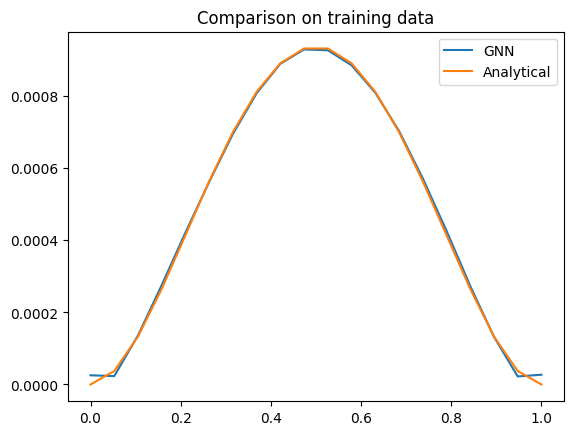

In [408]:
id = -1
pred = std_y_strain*gcn(graphs_train[id])+mean_y_train
x = jnp.linspace(0, L, num_nodes)
plt.plot(x, pred, label="GNN")
plt.plot(x, std_y_strain*y_train[id]+mean_y_train, label="Analytical")
plt.title("Comparison on training data")
plt.legend()
plt.show()

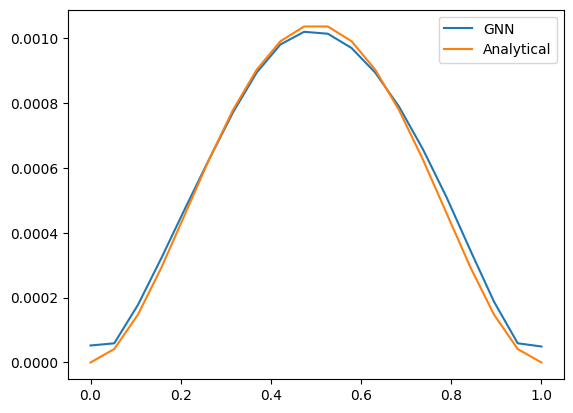

In [411]:
test_load = 0.8e5
norm_load = (test_load*jnp.ones(num_nodes).reshape(-1,1)-mean_train_loads)/std_train_loads
x = jnp.linspace(0, L, num_nodes)
mean_x = jnp.mean(x)
std_x = jnp.std(x)
norm_x = (x-mean_x)/std_x
features = jnp.hstack([norm_load, norm_x.reshape(-1,1)])
graph = create_rod_graph(num_nodes, features)
pred = std_y_strain*gcn(graph)+mean_y_train
y_theory = beam_deflection(x, L, test_load, E, I)
plt.plot(x, pred, label="GNN")
plt.plot(x, y_theory, label="Analytical")
plt.legend()
plt.show()

In [300]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define the MLP model
class RodDeformationMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RodDeformationMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Training function for MLP
def train_mlp(model, data_list, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in data_list:
        optimizer.zero_grad()
        out = model(data.x)  # MLP takes input features (position and load)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_list)


KeyboardInterrupt: 

In [ ]:
# Define the MLP
input_size = 2  # 2 input features: position and load
hidden_size = 64  # Same hidden size as the GNN
output_size = 1  # Output is the predicted deformation

mlp_model = RodDeformationMLP(input_size, hidden_size, output_size)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01)
mlp_criterion = nn.MSELoss()

# Training the MLP
mlp_num_epochs = 200
for epoch in range(mlp_num_epochs):
    mlp_loss = train_mlp(mlp_model, data_list, mlp_optimizer, mlp_criterion)
    if (epoch + 1) % 10 == 0:
        print(f'MLP Epoch {epoch+1}/{mlp_num_epochs}, Loss: {mlp_loss:.4f}')

# Evaluate MLP on a training example
with torch.no_grad():
    mlp_predicted_deformation_normalized = mlp_model(training_data.x)

# Denormalize the MLP predictions
mlp_predicted_deformation = mlp_predicted_deformation_normalized * deformation_std + deformation_mean

# Plot comparison between MLP and GNN predictions on training data
# plt.figure(figsize=(10, 6))
# plt.plot(training_data.x[:, 0].numpy(), predicted_deformation.numpy(), label='GNN Predicted Deformation (Training Data)')
# plt.plot(training_data.x[:, 0].numpy(), mlp_predicted_deformation.numpy(), label='MLP Predicted Deformation (Training Data)')
# plt.plot(training_data.x[:, 0].numpy(), (training_data.y * max_deformation).numpy(), label='True Deformation (Analytical)', linestyle='--')
# plt.title('GNN vs MLP vs True Deformation (Training Data)')
# plt.xlabel('Position along the beam')
# plt.ylabel('Deformation')
# plt.legend()
# plt.grid(True)
# plt.show()


In [ ]:

# -------------------
# Test load prediction for MLP
# -------------------

# Predict the deformation using the MLP for the test load
with torch.no_grad():
    mlp_predicted_test_deformation_normalized = mlp_model(test_graph.x)

# Denormalize the predicted deformation for the test load
mlp_predicted_test_deformation = mlp_predicted_test_deformation_normalized * deformation_std + deformation_mean

# Plot the comparison between GNN, MLP, and true deformation for the test load
plt.figure(figsize=(10, 6))
plt.plot(x_positions_numpy, predicted_test_deformation_numpy, label='GNN Predicted Deformation (Test Load)')
plt.plot(x_positions_numpy, mlp_predicted_test_deformation.numpy(), label='MLP Predicted Deformation (Test Load)')
plt.plot(x_positions_numpy, true_test_deformation_numpy, label='True Deformation (Analytical)', linestyle='--')
plt.title(f'GNN vs MLP vs True Deformation for Test Load = {test_load}')
plt.xlabel('Position along the beam')
plt.ylabel('Deformation')
plt.legend()
plt.grid(True)
plt.show()